# Simulated data

## 1: Implement subroutine generating random data

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# import statsmodels.api as sm
# from statsmodels.formula.api import ols

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


In [2]:
# Code received from Lukas
def generate_expression_data(n_analytes=100, n_samples=2, n_replicates=3, p_regulated=0.2, mean_offset=3.0, var=0.2, diff_var=2.0):
    # Here we follow a convension, The first sample is the reference i.e. have all label 1
    labels = npr.binomial(1, p_regulated, (n_analytes,n_samples-1))
    template = np.hstack((np.zeros((n_analytes,1)),labels))
    
    # We expand the template labels into several replicates
    regulated = np.repeat(template,n_replicates, axis=1)
    
    # If the reading is regulated, offset it with a random offset sampled from the normal distribution 
    offset = regulated*npr.normal(0,diff_var,(n_analytes,1))
    
    # Model a differentexpression level for the different analytes
    expr_level = np.ones((n_analytes,n_samples*n_replicates))*npr.normal(mean_offset,mean_offset,(n_analytes,1))
    
    # add noice for each measurement
    expression = npr.normal(offset+expr_level,var,(n_analytes,n_replicates*n_samples))
    expression = 2**expression
    
    analyte_names = ["a"+str(i+1) for i in range(n_analytes)]
    sample_names = ["s"+str(i+1)+'_'+str(j+1) for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe for expression values
    expr_df = pd.DataFrame(expression,columns=sample_names,index=analyte_names)
    expr_df.loc["Sample",:] = [i+1 for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe with answers if the reading was modeled as differential or not
    label_df = pd.DataFrame(template,columns=[i+1 for i in range(n_samples)],index=analyte_names)
                
    return expr_df,label_df

## 2: Generate testset of 10000 analytes under two conditions measured in 3 replicates.

In [3]:
diff_expr_df, diff_label_df = generate_expression_data(n_analytes=10000, n_samples=3, n_replicates=3, p_regulated=0.2)
null_expr_df, null_label_df = generate_expression_data(n_analytes=10000, n_samples=3, n_replicates=3, p_regulated=0)

diff_expr_df.columns = ["1", "1", "1", "2", "2", "2", "3", "3", "3"]


In [4]:
diff_expr_df.head()

,1,1,1,2,2,2,3,3,3
a1,0.933771,0.790261,1.114192,0.116993,0.115769,0.109801,0.888878,1.068254,0.956451
a2,34.815373,27.911198,31.486179,37.214290,35.619571,46.609361,37.724121,42.337400,45.829859
a3,3.296095,4.696901,3.427632,4.368915,3.662571,4.732659,3.792735,4.230375,3.543536
a4,13.844876,12.774950,11.221336,13.041672,12.558220,16.705133,14.582620,15.911192,12.007651
a5,194.848094,181.362143,172.124870,193.514093,221.440540,221.176723,185.349082,166.987464,177.884903


In [24]:
diff_label_df.head()

,1,2,3
a1,0.0,1.0,0.0
a2,0.0,1.0,1.0
a3,0.0,0.0,0.0
a4,0.0,0.0,0.0
a5,0.0,0.0,0.0


## 3: Calculate p-values

Example t-test.

In [5]:
def get_anova_p_from_row(row):
    row_df = pd.DataFrame({"sample":row.index, "value":row})
    row_fit = ols('value ~ C(sample)', data=row_df).fit()
    report = anova_lm(row_fit, type=2)
    anova_p = report.loc["C(sample)", "PR(>F)"]
    return anova_p

row = diff_expr_df.iloc[1,:]
get_anova_p_from_row(row)

/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0.066660201841030234

In [7]:
diff_p_vals = diff_expr_df.apply(get_anova_p_from_row, axis=1)

/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## 4: Implement subroutine for calculating q-value

* Let p_1 <= p_2 <= p_m be ordered p-values
* For a range lambda, say lambda = 0, 0.01, 0.02.., 0.95 calculate: pi0(lambda) = # {p_j > lambda} / m(1-lambda)
* Let f be the natural cubic spline (in our case - average for high p-values)
* Set estimate of pi_0 to be: pi_0 = f(1)
* Calculate q(p(m)) = min((pi_0*m*t)/#{p_i <= t}) = pi_0 * p(m)
* For i = m - 1, m - 2, ..., 1 calculate:
* The estimated q is the ith most significant feaure is q(p(i))

In [9]:
def estimate_pis(pvals):
    
    pi_0_vals = list()
    
    for sub_thres in np.arange(0.01, 0.96, 0.01):
        sub_p = [p for p in pvals if p > sub_thres]
        sub_p_count = len(sub_p)
        m = len(pvals)
        pi_0 = sub_p_count / (m * (1-sub_thres))
        pi_0_vals.append(pi_0)
  
    return pi_0_vals

def estimate_pi_zero(pis, thres):
    
    tot = len(pis)
    start_ind = int(tot * thres)
    sub = pis[start_ind:]
    return np.mean(sub)


### Diff test

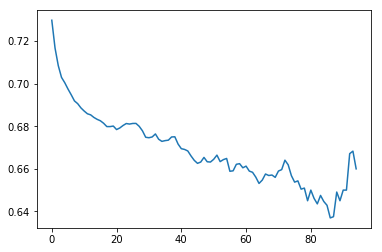

In [10]:
diff_pi_0_vals = estimate_pis(diff_p_vals)
plt.plot(diff_pi_0_vals)
plt.show()

### Null test

#### q-value calculations

In [11]:
def estimate_q_vals(pvals):
    pi_estimates = estimate_pis(pvals)
    pi_0 = estimate_pi_zero(pi_estimates, 0.75)
    m = len(pvals)
    
    fdr_vals = list()
    for t in sorted(pvals):
#     for i in range(len(pvals)):
        val = pi_0 * m * t / (len(fdr_vals) + 1)
        fdr_vals.append(val)
#         q_vals.append(min(fdr_vals))

    q_vals = list()
    for sub_i in range(1, len(fdr_vals)):
        fdr_slice = fdr_vals[len(fdr_vals) - sub_i:]
        q = min(fdr_slice)
        q_vals.insert(0, q)

    print("pi_0: {}".format(pi_0))
    print("m: {}".format(len(pvals)))
    return q_vals
    



In [35]:
diff_q_vals = estimate_q_vals(diff_p_vals)


pi_0: 0.6514181610807127
m: 10001


In [36]:
print(diff_q_vals[0:10])

[5.1247842984501292e-08, 5.2525237758337872e-08, 8.2928956960953823e-08, 1.7533073233339596e-07, 2.6016412544117981e-07, 4.0341299094692029e-07, 5.243216140953118e-07, 8.0187354535357491e-07, 8.6869996827728548e-07, 1.0005299501299569e-06]


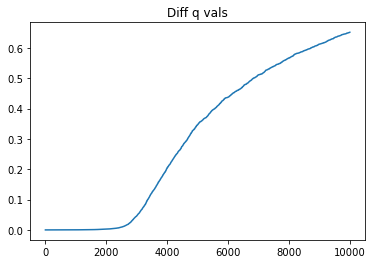

In [37]:
plt.plot(diff_q_vals)
plt.title("Diff q vals")
plt.show()

## 5: Differential expression genes, on q-threshold

In [38]:
xvals = np.arange(0, 0.5, 0.005)

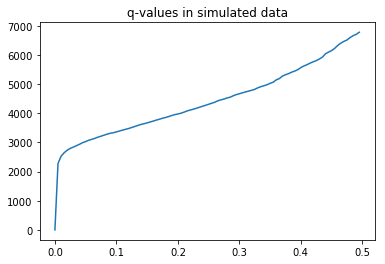

In [39]:
diff_counts = list()
for thres in xvals:
    diff_count = len([q for q in diff_q_vals if q <= thres])
    diff_counts.append(diff_count)
plt.plot(xvals, diff_counts)
plt.title('q-values in simulated data')
plt.show()

# 6: Plot difference between q-values and actual fraction of null statistics

In [17]:
diff_q_vals[0:10]

[5.1247842984501292e-08,
 5.2525237758337872e-08,
 8.2928956960953823e-08,
 1.7533073233339596e-07,
 2.6016412544117981e-07,
 4.0341299094692029e-07,
 5.243216140953118e-07,
 8.0187354535357491e-07,
 8.6869996827728548e-07,
 1.0005299501299569e-06]

In [18]:
diff_p_vals[0:10]

a1     0.000099
a2     0.066660
a3     0.611133
a4     0.558910
a5     0.028877
a6     0.801048
a7     0.486519
a8     0.278760
a9     0.549225
a10    0.144559
dtype: float64

In [55]:
def get_true_diff_counts(pvals, labels, xvals):
    
    true_rows_col2 = labels.iloc[:,1] == 1
    true_rows_col3 = labels.iloc[:,2] == 1
    true_rows = list(np.array(true_rows_col2) | np.array(true_rows_col3))
    
    print(len(true_rows))
    print(list(true_rows)[0:10])
    true_pvals = pvals[list(true_rows)]
    
    below_thres_counts = list()
    for thres in xvals:
        below_thres_count = [p for p in true_pvals if p <= thres]
        below_thres_counts.append(len(below_thres_count))
    
    return below_thres_counts

In [62]:
true1 = diff_label_df.iloc[:,1] == 1
true2 = diff_label_df.iloc[:,2] == 1
true_rows = list(np.array(true1) | np.array(true2))
print(pd.DataFrame({"c1":list(true1), "c2":list(true2), "rows":list(true_rows)}).head())
# print(true2)

      c1     c2   rows
0   True  False   True
1   True   True   True
2  False  False  False
3  False  False  False
4  False  False  False


In [63]:
true_diff_counts = get_true_diff_counts(diff_p_vals, diff_label_df, xvals)

10000
[True, True, False, False, False, False, False, False, False, True]


/usr/local/anaconda/lib/python3.6/site-packages/pandas/core/internals.py:258: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10001 but corresponding boolean dimension is 10000
  return self.values[slicer]
/usr/local/anaconda/lib/python3.6/site-packages/pandas/core/indexes/base.py:1650: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10001 but corresponding boolean dimension is 10000
  result = getitem(key)


In [64]:
q_estimated_h1_count = list()
for i in range(len(true_diff_counts)):
    diff_count = diff_counts[i]
    x_frac = xvals[i]
    est_actual_diff_count = diff_count - diff_count * x_frac
    q_estimated_h1_count.append(est_actual_diff_count)

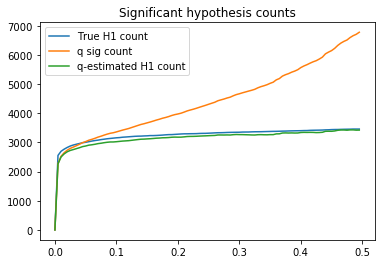

In [65]:
true_counts = plt.plot(xvals, true_diff_counts, label="True H1 count")
q_counts = plt.plot(xvals, diff_counts, label="q sig count")
q_est_true = plt.plot(xvals, q_estimated_h1_count, label="q-estimated H1 count")
plt.legend()
plt.title("Significant hypothesis counts")
plt.show()